#### TSE, DEFI IA, Baseline.
#### Raphaël Sourty

In [ ]:
import os
import pandas as pd

### Load and clean train set:

I chose to rename some columns of the data. These data is a good example of what to avoid. In Python we should always name our columns in lower case and separate the words with an underscore. The variable "station" replaces "number_sta". I'm deliberately getting rid of the date. We won't need it, it is not defined in the test data. The day is now an integer from 0 to 729 (729 for the last day of the second year). I also created a test column that will distinguish test data from training data.

In [ ]:
train = pd.read_csv(
    'Y_train.csv', delimiter=',', 
    parse_dates=['date'], 
    infer_datetime_format=True,
    dtype = {"number_sta": int, "Ground_truth": float},
).rename(
    columns = {"Ground_truth": "y", "Id": "id", "number_sta": "station"}
).sort_values(["date", "station"]).assign(test=False)

train["month"] = train.date.dt.month.astype(int)
train["day"] = train["id"].str.split("_").str[1].astype(int)
train = train.drop("date", axis = "columns")

In [ ]:
train.head()

,station,y,id,test,month,day
0,14066001,3.4,14066001_0,False,1,0
1,14126001,0.5,14126001_0,False,1,0
2,14137001,3.4,14137001_0,False,1,0
3,14216001,4.0,14216001_0,False,1,0
4,14296001,13.3,14296001_0,False,1,0


### Load and clean test:

I apply the same logic to the test data, my goal being to gather in the same dataframe the test data and the training data in order to calculate the features more easily.

In [ ]:
test = pd.read_csv(
   'Baseline_observation_test.csv',
    dtype = {"Prediction": float}
).assign(Prediction=None, test=True).rename(columns = {"Prediction": "y", "Id": "id", "number_sta": "station"})

test["day"] = test["id"].str.split("_").str[1].astype(int)

test = pd.merge(
    left = test,
    right = pd.read_csv('Id_month_test.csv').rename(columns = {"day_index": "day"}),
    on = ["day"],
    how = "left",
)

test["station"] = test["id"].str.split("_").str[0].astype(int)

In [ ]:
test.head()

,id,y,test,day,month,station
0,14066001_149,None,True,149,1,14066001
1,14126001_149,None,True,149,1,14126001
2,14137001_149,None,True,149,1,14137001
3,14216001_149,None,True,149,1,14216001
4,14296001_149,None,True,149,1,14296001


#### Concat training set and test set:

The training and test data are formatted in the same way, so we can concatenate them. The df dataframe will now be the main dataset. We will add the features to this datafarame `df`. Features are new columns to help us estimate the target variable, we create these features manually. I also choose to delete the `id` column because I can easily find it from the station variable and the day variable.

In [ ]:
df = pd.concat([train, test], axis = "rows")
df = df.drop("id", axis = "columns")
df.head()

,station,y,test,month,day
0,14066001,3.4,False,1,0
1,14126001,0.5,False,1,0
2,14137001,3.4,False,1,0
3,14216001,4,False,1,0
4,14296001,13.3,False,1,0


#### Station latitude, longitude, height

I will add to the df dataframe `df` the latitude and longitude data set.

In [ ]:
stations = pd.read_csv(
    'stations_coordinates.csv',
    dtype = {"number_sta": int}         
).rename(
    columns={"number_sta": "station", "lat": "latitude", "lon": "longitude", "height_sta": "height"}
)

In [ ]:
stations.head()

,station,latitude,longitude,height
0,86118001,46.477,0.985,120.0
1,86149001,46.917,0.025,60.0
2,56081003,48.050,-3.660,165.0
3,53215001,47.790,-0.710,63.0
4,22135001,48.550,-3.380,148.0


In [ ]:
df = pd.merge(
    left = df,
    right = stations,
    on = "station",
    how = "left",
)

In [ ]:
df.head()

,station,y,test,month,day,latitude,longitude,height
0,14066001,3.4,False,1,0,49.334,-0.431,2.0
1,14126001,0.5,False,1,0,49.145,0.042,125.0
2,14137001,3.4,False,1,0,49.180,-0.456,67.0
3,14216001,4,False,1,0,48.928,-0.149,155.0
4,14296001,13.3,False,1,0,48.795,-1.037,336.0


#### Loading the training features:

The files `data/Test/X_station_test.csv` and `data/Train/X_station_train.csv` contain the available weather stations records with a fine granularity (record per station and per hour). We will use this data to enrich the `df` dataframe that we have previously created. We will have to aggregates those features to add them to our dataframe `df`.

First I will start by loading these data and cleaning them.

In [ ]:
train_features = pd.read_csv(
    'X_station_train.csv',
    parse_dates=['date'], 
    infer_datetime_format=True,
    dtype = {"number_sta": int},
).rename(
    columns = {"number_sta": "station", "Id": "id"}
).assign(test=False)

train_features["month"] = train_features["date"].dt.month.astype(int)
train_features["day"] = train_features["date"].dt.day.astype(int)
train_features["hour"] = train_features["date"].dt.hour.astype(int)

train_features = train_features.drop(["date", "id"], axis = "columns")

In [ ]:
train_features

,station,ff,t,td,hu,dd,precip,test,month,day,hour
0,14066001,3.05,279.28,277.97,91.4,200.0,0.0,False,1,1,0
1,14066001,2.57,278.76,277.45,91.4,190.0,0.0,False,1,1,1
2,14066001,2.26,278.27,277.02,91.7,181.0,0.0,False,1,1,2
3,14066001,2.62,277.98,276.95,93.0,159.0,0.0,False,1,1,3
4,14066001,2.99,277.32,276.72,95.9,171.0,0.0,False,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...
372704,35228001,10.23,281.19,277.33,76.7,301.0,0.0,False,3,3,0
372705,35228001,9.72,280.19,277.25,81.8,298.0,0.4,False,3,3,1
372706,35228001,10.61,280.46,277.02,78.9,300.0,0.4,False,3,3,2
372707,35228001,9.51,280.62,276.96,77.7,305.0,0.4,False,3,3,3


In [ ]:
train_features.head()

,station,ff,t,td,hu,dd,precip,test,month,day,hour
0,14066001,3.05,279.28,277.97,91.4,200.0,0.0,False,1,1,0
1,14066001,2.57,278.76,277.45,91.4,190.0,0.0,False,1,1,1
2,14066001,2.26,278.27,277.02,91.7,181.0,0.0,False,1,1,2
3,14066001,2.62,277.98,276.95,93.0,159.0,0.0,False,1,1,3
4,14066001,2.99,277.32,276.72,95.9,171.0,0.0,False,1,1,4


#### Loading the test features:

I apply the same logic to the test features to be able to concatenate all the test and train features. We can then build aggregates and join them to the `df` dataframe.

In [ ]:
test_features = pd.read_csv(
    'X_station_test.csv', 
).rename(
    columns = {"Id": "id"}
).assign(test=True)

In [ ]:
test_features

,dd,hu,td,t,ff,precip,month,id,test
0,NaN,NaN,NaN,278.35,NaN,NaN,12,14047002_277_4,True
1,NaN,NaN,NaN,278.40,NaN,0.0,12,14047002_277_5,True
2,NaN,NaN,NaN,279.01,NaN,0.0,12,14047002_277_6,True
3,NaN,NaN,NaN,279.66,NaN,0.0,12,14047002_277_7,True
4,NaN,NaN,NaN,279.99,NaN,0.0,12,14047002_277_8,True
...,...,...,...,...,...,...,...,...,...
208314,143.0,98.0,282.22,282.52,1.99,0.4,2,85163001_54_21,True
208315,149.0,98.0,282.06,282.36,2.11,0.0,2,85163001_54_22,True
208316,161.0,98.0,282.02,282.32,2.12,0.0,2,85163001_54_23,True
208317,194.0,NaN,NaN,279.05,1.43,0.2,2,85169002_54_0,True


In [ ]:
test_features["station"] = test_features["id"].str.split("_").str[0].astype(int)
test_features["day"] = test_features["id"].str.split("_").str[1].ffill().astype(int)
test_features["hour"] = test_features["id"].str.split("_").str[2].ffill().astype(int)

In [ ]:
test_features = test_features.drop(["id"], axis = "columns")

#### Features

I now create the `features` dataframe. This dataframe will contain all the records useful for creating features for the `df` data set.

In [ ]:
features = pd.concat([train_features, test_features], axis = "rows")

In [ ]:
features.head()

,station,ff,t,td,hu,dd,precip,test,month,day,hour
0,14066001,3.05,279.28,277.97,91.4,200.0,0.0,False,1,1,0
1,14066001,2.57,278.76,277.45,91.4,190.0,0.0,False,1,1,1
2,14066001,2.26,278.27,277.02,91.7,181.0,0.0,False,1,1,2
3,14066001,2.62,277.98,276.95,93.0,159.0,0.0,False,1,1,3
4,14066001,2.99,277.32,276.72,95.9,171.0,0.0,False,1,1,4


#### New Features

Let's start create new features since we have our two clean dataframes `df` and `features`. Our main objective will be to create aggregates of the `features` dataframe and then perform left-join to the `df` dataframe.

In [ ]:
def make_agg(x, on, by, how):
    """Function to make aggregates easilly.
    
    Parameters
    ----------
        x (pd.DataFrame): Features dataframe.
        on (list): List of targets aggregates.
        by (list): List of columns we will use to group data.
        how (list): List of statistics.
    
    """
    columns = []
    for col in on:
        for stat in how:
            columns.append(f"{stat}_{col}_by_{'_'.join(by)}")
    x = x.groupby(by)[on].agg(how)  
    x.columns = columns
    return x
    

For example, here is a set of features that might be useful. We compute the mean, sum and standard deviation of variables `["ff", "t", "td", "hu", "dd", "precip"]` grouped by `["station", "day"]`.

In [ ]:
make_agg(
    x = features, 
    on = ["ff", "t", "td", "hu", "dd", "precip"], 
    by = ["station", "day"], 
    how = ["mean", "sum", "std"]
)

mean_ff_by_station_day  ...  std_precip_by_station_day
station  day                          ...                           
14047002 31                      NaN  ...                   0.000000
         39                      NaN  ...                   0.734144
         100                     NaN  ...                   0.696771
         223                     NaN  ...                   0.127404
         236                     NaN  ...                   0.583778
...                              ...  ...                        ...
95690001 293                1.367500  ...                   0.040825
         301                1.515000  ...                   0.000000
         314                8.535417  ...                   0.583592
         329                2.208333  ...                   0.000000
         344                4.096250  ...                   0.429020

[15966 rows x 18 columns]

We just have to join these new features with the `pd.merge` method:

In [ ]:
agg = make_agg(
    x = features, 
    on = ["ff", "t", "td", "hu", "dd", "precip"], 
    by = ["station", "day"], 
    how = ["mean", "sum", "std"]
)


df = pd.merge(
    left = df,
    right = agg,
    on = ["station", "day"],
    how = "left",
)

#### Todo: add features

#### Train test split:

We separate the test game from the training game here to proceed with the model training and inference.

In [ ]:
# The "test" column is a boolean column which is equal to True for test and False for train.
X_train = df[df["test"] == False].copy()
X_test = df[df["test"]].copy()

Some of the samples in the target variable are missing, we will drop it for now but it could be interesting to retrieve them:

In [ ]:
X_train = X_train[X_train["y"].notnull()]

# y_train is the target variable to train our model.
y_train = X_train["y"].astype(float).copy()

We re-create the id for the submission and set it as the index of X_test

In [ ]:
X_test["id"] = X_test["station"].astype(str) + "_" + X_test["day"].astype(str)
X_test = X_test.set_index("id")

We will need to drop some columns to avoid errors such as station, test and day and y. 

In [ ]:
columns_to_drop = ["station", "y", "test", "day"]

X_train = X_train.drop(columns_to_drop, axis = "columns")
X_test = X_test.drop(columns_to_drop, axis = "columns")

In [ ]:
X_train.head()

,month,latitude,longitude,height,mean_ff_by_station_day,sum_ff_by_station_day,std_ff_by_station_day,mean_t_by_station_day,sum_t_by_station_day,std_t_by_station_day,mean_td_by_station_day,sum_td_by_station_day,std_td_by_station_day,mean_hu_by_station_day,sum_hu_by_station_day,std_hu_by_station_day,mean_dd_by_station_day,sum_dd_by_station_day,std_dd_by_station_day,mean_precip_by_station_day,sum_precip_by_station_day,std_precip_by_station_day
0,1,49.334,-0.431,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,49.145,0.042,125.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,49.180,-0.456,67.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,48.928,-0.149,155.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,48.795,-1.037,336.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
X_test.head()

,month,latitude,longitude,height,mean_ff_by_station_day,sum_ff_by_station_day,std_ff_by_station_day,mean_t_by_station_day,sum_t_by_station_day,std_t_by_station_day,mean_td_by_station_day,sum_td_by_station_day,std_td_by_station_day,mean_hu_by_station_day,sum_hu_by_station_day,std_hu_by_station_day,mean_dd_by_station_day,sum_dd_by_station_day,std_dd_by_station_day,mean_precip_by_station_day,sum_precip_by_station_day,std_precip_by_station_day
id,,,,,,,,,,,,,,,,,,,,,,
14066001_149,1,49.334,-0.431,2.0,5.237917,125.71,1.805901,282.099583,6770.39,1.415856,279.107917,6698.59,1.100198,81.720833,1961.3,5.016753,224.625000,5391.0,23.384894,0.058333,1.4,0.285774
14126001_149,1,49.145,0.042,125.0,NaN,0.00,NaN,280.895833,6741.50,1.114033,279.718750,6713.25,1.359493,92.291667,2215.0,3.697580,NaN,0.0,NaN,0.041667,1.0,0.204124
14137001_149,1,49.180,-0.456,67.0,5.547083,133.13,1.853623,281.167917,6748.03,1.710721,278.469583,6683.27,1.403252,83.266667,1998.4,4.955775,218.458333,5243.0,26.131738,0.016667,0.4,0.081650
14216001_149,1,48.928,-0.149,155.0,2.667083,64.01,1.020667,280.804583,6739.31,1.552857,278.105417,6674.53,1.477365,83.345833,2000.3,6.885270,207.375000,4977.0,32.714593,0.033333,0.8,0.127404
14296001_149,1,48.795,-1.037,336.0,NaN,0.00,NaN,279.570417,6709.69,1.042090,NaN,0.00,NaN,NaN,0.0,NaN,NaN,0.0,NaN,0.150000,3.6,0.547723


#### Handle missing values:

I choose to replace the missing values by -1, there are surely better solutions to replace the missing values.

#### Cross-validation

I choose here to use the LightGbm model. It is a very powerful model that wins most of the machine learning competitions. It is interesting because we can use it to measure the weight of features in the decision making of the model. Moreover, the Lightgbm API is quite practical. It is important to look for the best model parameters.

In the framework of the tutorials we will use many other models. The winning solution of the DEFI AI contest will be built from a set of models. We will come back to this later.

Documentation to install LightGBM: [lightgbm](https://lightgbm.readthedocs.io/en/latest/Installation-Guide.html).

In [ ]:
import lightgbm as lgbm
!pip install sklearn
from sklearn import model_selection
from sklearn import metrics


# Seen on  https://stats.stackexchange.com/questions/58391/mean-absolute-percentage-error-mape-in-scikit-learn :
# " As noted (for example, in Wikipedia), MAPE can be problematic. Most pointedly, it can cause division-by-zero errors "

# We implement it using the code of user Antonín Hoskovec


import numpy as np
from sklearn.model_selection import GridSearchCV

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

param = [{"boosting_type": ['gbdt','dart'], "learning_rate": [0.001, 0.01, 0.1, 0.2], "reg_alpha": [0.001, 0.01, 0.1], "reg_lambda": [0.001, 0.01, 0.1]}]

#  Fold:
k = 5

cv = model_selection.KFold(k, shuffle=True, random_state=42)


model = lgbm.LGBMRegressor(
    n_estimators=500, # Number of trees

    random_state=42,
)

grid_search_cv = GridSearchCV(model, param, cv=5)

error_validation = 0

sub = pd.Series(0.0, index=X_test.index)

for fit_idx, val_idx in cv.split(X_train, y_train):

    X_fit = X_train.iloc[fit_idx]
    X_val = X_train.iloc[val_idx]
    
    y_fit = y_train.iloc[fit_idx] 
    y_val = y_train.iloc[val_idx]

 '''   model.fit(
        X_fit,
        y_fit,
        eval_set=[(X_fit, y_fit), (X_val, y_val)],
        eval_names=("fit", "val"),
        eval_metric="l2",
        early_stopping_rounds = 500,
        feature_name = X_fit.columns.tolist()
    )
'''

    fuck = grid_search_cv.fit(X_fit,y_fit)

    # Computation of the loss
    print("Best learning rate = %f, Best parameter  = %s" %
      (1.-fuck.best_score_, fuck.best_params_))




    # Validation predictions:
    error_validation += mean_absolute_percentage_error(
        y_true = model.predict(X_val) + 1, 
        y_pred = y_val + 1,
    ) / k
    
    # Bagging
    # Since we train 5 models using cross-validation with k=5 folds, we average the prediction of each models.
    # It helps a lot!
    sub += model.predict(X_test) / k
    
# To avoid zero-division errors, METEO FRANCE added 1 to the target variable, so we do it too.
sub += 1

[1]	fit's l2: 17.2683	fit's l2: 17.2683	val's l2: 17.6062	val's l2: 17.6062
Training until validation scores don't improve for 500 rounds.
[2]	fit's l2: 17.0681	fit's l2: 17.0681	val's l2: 17.4104	val's l2: 17.4104
[3]	fit's l2: 16.9089	fit's l2: 16.9089	val's l2: 17.2657	val's l2: 17.2657
[4]	fit's l2: 16.7779	fit's l2: 16.7779	val's l2: 17.1377	val's l2: 17.1377
[5]	fit's l2: 16.6578	fit's l2: 16.6578	val's l2: 17.025	val's l2: 17.025
[6]	fit's l2: 16.5639	fit's l2: 16.5639	val's l2: 16.9359	val's l2: 16.9359
[7]	fit's l2: 16.4724	fit's l2: 16.4724	val's l2: 16.8518	val's l2: 16.8518
[8]	fit's l2: 16.3923	fit's l2: 16.3923	val's l2: 16.7816	val's l2: 16.7816
[9]	fit's l2: 16.3211	fit's l2: 16.3211	val's l2: 16.715	val's l2: 16.715
[10]	fit's l2: 16.2599	fit's l2: 16.2599	val's l2: 16.66	val's l2: 16.66
[11]	fit's l2: 16.2078	fit's l2: 16.2078	val's l2: 16.6124	val's l2: 16.6124
[12]	fit's l2: 16.1632	fit's l2: 16.1632	val's l2: 16.5723	val's l2: 16.5723
[13]	fit's l2: 16.1205	fit's l

In [ ]:

from sklearn.model_selection import GridSearchCV

param = [{"boosting_type": ['gbdt','dart'], "learning_rate": [0.001, 0.01, 0.1, 0.2], "reg_alpha": [0.001, 0.01, 0.1], "reg_lambda": [0.001, 0.01, 0.1]}]

#  Fold:
k = 5

cv = model_selection.KFold(k, shuffle=True, random_state=42)


model = lgbm.LGBMRegressor(
    n_estimators=500, # Number of trees

    random_state=42,
)

grid_search_cv = GridSearchCV(model, param, cv=5)

error_validation = 0

sub = pd.Series(0.0, index=X_test.index)

for fit_idx, val_idx in cv.split(X_train, y_train):

    X_fit = X_train.iloc[fit_idx]
    X_val = X_train.iloc[val_idx]
    
    y_fit = y_train.iloc[fit_idx] 
    y_val = y_train.iloc[val_idx]

    loss = grid_search_cv.fit(X_fit,y_fit)

    # Computation of the loss
    print("Best learning rate = %f, Best parameter  = %s" %
      (1.-loss.best_score_, loss.best_params_))
    

# Ajouter les features de façon incrémentale dans la pipeline

In [ ]:
print(f"MAPE on validation set: {error_validation}")

MAPE on validation set: 85.02525572559013


#### Your main goal is to reduce the value of this metric, i.e. make fewer errors. If you create a feature that does not reduce MAPE then you can throw it away. For each feature you create, you should re-execute the notebook and verify that the feature helps. The order in which you create the features does not matter. You should start by building the simplest features.

#### Weight of our features

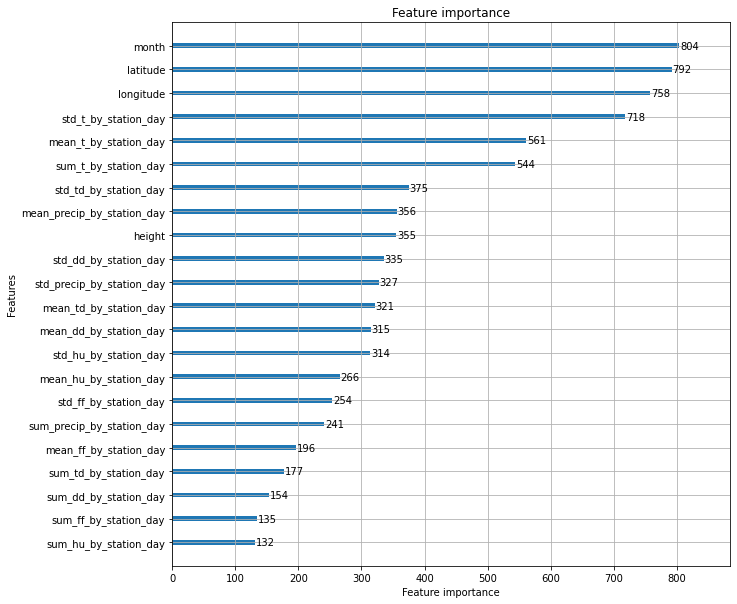

In [ ]:
lgbm.plot_importance(model._Booster, figsize=(10, 10))

#### Our submission:

In [ ]:
sub = sub.rename("Prediction").reset_index().rename(columns = {"id": "Id"})

In [ ]:
sub.to_csv("submission.csv", index=False)
sub

,Id,Prediction
0,14066001_149,3.709203
1,14126001_149,3.733846
2,14137001_149,3.360690
3,14216001_149,3.787659
4,14296001_149,4.979128
...,...,...
85135,86137003_293,0.725043
85136,86165005_293,0.836094
85137,86273001_293,1.732322
85138,91200002_293,0.667034


#### How to improve this notebook:

- Create a lots of features that reduce the MAPE
- Handle missing values
- Handle outliers, i.e extreme values
- Tune the hyperparameters of your model
- Create multiples models (Blending / Stacking)

- Predict the error rather that the target variable directly, [METEO FRANCE MODELS LINK, available soon](https://meteonet.umr-cnrm.fr/dataset/data/defi_ia_challenge/).


#### Useful resources:

https://maxhalford.github.io/blog/target-encoding/

https://explained.ai/gradient-boosting/